In [20]:
%load_ext autoreload
%autoreload 2
import sys
import pandas as pd
import numpy as np
import transformers
import os
import re
import plotly.express as px
import plotly.graph_objects as go
import torch
import torch.nn as nn
import sys
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# PREPROCESSING 

##  1) Custom Dataset Class
#### Implement a map-style dataset from .csv files; needed because data files train_titles.csv and test_titles.csv cannot be directly passed to the dataloader

In [21]:
import os
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset

class customTextDataset(Dataset):
    def __init__(self, path, colnames, maxLen, tokenizer=None): 
        self.data =  pd.read_csv(path, names=colnames, header=None, sep = ',', index_col=False)
        self.tokenizer = tokenizer
        self.maxLen = maxLen

    def __getitem__(self, idx):
        sentence = self.data.loc[idx].text
        ids = self.tokenizer(self.tokenizer.bos_token + ' ' + sentence + ' ' + self.tokenizer.eos_token,  padding = 'max_length', truncation = True, max_length = self.maxLen)['input_ids']
        ids = torch.tensor(ids)
        # mask
        padId = torch.unsqueeze(torch.tensor(self.tokenizer.encode(self.tokenizer.pad_token)[0]),axis=-1)
        mask = (ids == padId)
        mask = mask.repeat(self.maxLen,1)
        label = self.data.loc[idx].food
        return ids, mask, label
        #return torch.tensor(ids),label # torch.tensor(sentence), mask, label
 
    def __len__(self):
        return len(self.data)

    def getHead(self):
        print(self.data.head())

## 2) GPT2 Tokenizer using Huggingface

In [22]:
from torch.utils.data import DataLoader
maxLen = 32
batchSize = 512
from transformers import GPT2Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
numAdded = tokenizer.add_special_tokens({'pad_token': '[PAD]', 'bos_token':'[BOS]','eos_token':'[EOS]','unk_token':'[UNK]'})
print(f'Number of added tokens = {numAdded}')
padId,bosId,eosId,unkId  = (tokenizer.encode(tokenizer.pad_token)[0], tokenizer.encode(tokenizer.bos_token)[0], tokenizer.encode(tokenizer.eos_token)[0], tokenizer.encode(tokenizer.unk_token)[0]) 
print(f'TokenIds = {padId, bosId, eosId,unkId}')
vocabSize = len(tokenizer)

Number of added tokens = 4
TokenIds = (50257, 50258, 50259, 50260)


## 3) Create Dataloaders from Custom Text Dataset

In [23]:
trainData = customTextDataset(path = 'train_titles.csv', colnames=['image_path', 'text', 'food'], tokenizer = tokenizer,maxLen=maxLen)
trainLoader = DataLoader(trainData,batch_size=batchSize,shuffle=True)
print(f'Number of train data points  = {trainData.__len__()}')
#trainData.getHead()
testData = customTextDataset(path = 'test_titles.csv', colnames=['image_path', 'text', 'food'], tokenizer = tokenizer,maxLen=maxLen)
testLoader = DataLoader(testData,batch_size=testData.__len__(),shuffle=True)
print(f"Number of test data points = {testData.__len__()}")

Number of train data points  = 67972
Number of test data points = 22716


#### Print an example data point (tokens/tokenIds) and label

In [24]:
data = next(iter(trainLoader))
print(f"Encoded Text = {data[0][0]}")
print(f"Mask = {data[1][0][0]}, {data[1][0].type()}, {data[1][0].shape}")
print(f"Encoded Label = {data[2][0]}")
print(f"Check - Decoded tokens from encoded ids: \n{tokenizer.decode(data[0][0])}")

Encoded Text = tensor([50258, 16789, 16405, 15442, 13823, 26694,   220, 50259, 50257, 50257,
        50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
        50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
        50257, 50257])
Mask = tensor([False, False, False, False, False, False, False, False,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True]), torch.BoolTensor, torch.Size([32, 32])
Encoded Label = fried_rice
Check - Decoded tokens from encoded ids: 
[BOS] Easy Chicken Fried Rice Recipe [EOS][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD]


## 4) Convert categorical labels (recipe names) to numerical labels ({0,1,2,....101})

In [25]:
labelsTrain_ = []
for data in trainLoader:
    labelsTrain_ = labelsTrain_ + (list(data[2]))
  
from collections import Counter
labelsDict = Counter(labelsTrain_)
keys = labelsDict.keys()
lblMap = {x:i for i,x in enumerate(keys)}

# LSTM + FEEDFORWARD MODEL

In [26]:
class trnsfrmrClassifier(torch.nn.Module):
    def __init__(self,vocab_size, embedding_dim, hidden_size, nClasses, padId):
        super(trnsfrmrClassifier, self).__init__()
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        #self.LSTM = nn.LSTM(input_size = embedding_dim, hidden_size = hidden_size,batch_first=True)
        #self.bn = nn.BatchNorm1d(hidden_size)
        self.FC0 = nn.Linear(32,1)
        self.drop1 = nn.Dropout(p = 0.5)
        self.FC1 = nn.Linear(hidden_size,256)
        self.drop2 = nn.Dropout(p = 0.5)
        self.FC2 = nn.Linear(256,nClasses)
        self.Relu = torch.nn.ReLU()
        self.padId = padId
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=1,batch_first=True)
        

    def forward(self, x_,mask):
        x = self.word_embeddings(x_) # input dimensions are (batch size, sqeuenquence length) - output dimensions are (batch size, sequence length, feature size)
        #LSTM
        #x[x_ == self.padId, :] = 0 # set rows, where each row is of dimension equal to feature size, corresponding to pad id = 0
        #(x,_) = self.LSTM(x)        
        #x = x[:, -1, :] # gives two dimensional output, not three dimensional output -  we are retaining the last hidden state          
        # Transformer Ecnoder
        x = self.encoder_layer(src = x, src_mask = mask) # output is number of words x embedding_dim
        x = self.FC0.forward((torch.transpose(x,1,2)))
        x = self.drop1(x)               
        x = torch.squeeze(x,axis = -1)
        x = self.Relu(self.FC1(x))
        x = self.drop2(x)
        x = self.FC2(x)
        return x

In [27]:
import numpy
from transformers import GPT2Config
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
hidden_size = 100
dModel = 100
numClasses = 101
model = trnsfrmrClassifier(vocab_size=vocabSize, 
                 embedding_dim = dModel,
                 hidden_size=hidden_size, nClasses = numClasses, padId = padId
                )

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.005)
lossVals = []
model = model.to(device)
print(model)

trnsfrmrClassifier(
  (word_embeddings): Embedding(50261, 100)
  (FC0): Linear(in_features=32, out_features=1, bias=True)
  (drop1): Dropout(p=0.5, inplace=False)
  (FC1): Linear(in_features=100, out_features=256, bias=True)
  (drop2): Dropout(p=0.5, inplace=False)
  (FC2): Linear(in_features=256, out_features=101, bias=True)
  (Relu): ReLU()
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=100, out_features=100, bias=True)
    )
    (linear1): Linear(in_features=100, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=100, bias=True)
    (norm1): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
)


## 1) Train LSTM + Feedforward Model

In [28]:
for epoch in range(35):  # loop over the dataset multiple times
    for data in trainLoader:
        ids,masks,labels_ = data
        labels = torch.tensor([lblMap[x] for x in labels_])
        optimizer.zero_grad()
        outputs = model(ids,masks)
        loss = criterion(outputs, labels)
        loss.backward()
        lossVals.append(loss.detach().cpu().clone().numpy())
        optimizer.step()
    if epoch%1 == 0:
        print(f"Epoch = {epoch}. Loss = {loss}")
print('Finished Training')

Epoch = 0. Loss = 1.7971256971359253
Epoch = 1. Loss = 1.2508472204208374
Epoch = 2. Loss = 1.1485995054244995
Epoch = 3. Loss = 1.1220030784606934
Epoch = 4. Loss = 0.9266741275787354
Epoch = 5. Loss = 0.8125954866409302
Epoch = 6. Loss = 0.8648331761360168
Epoch = 7. Loss = 0.7927772998809814
Epoch = 8. Loss = 0.8183512687683105
Epoch = 9. Loss = 0.7625884413719177
Epoch = 10. Loss = 0.6449345946311951
Epoch = 11. Loss = 0.6503838896751404
Epoch = 12. Loss = 0.6329066753387451
Epoch = 13. Loss = 0.7060551047325134
Epoch = 14. Loss = 0.581666111946106
Epoch = 15. Loss = 0.6687570214271545
Epoch = 16. Loss = 0.6020787954330444
Epoch = 17. Loss = 0.5149263739585876
Epoch = 18. Loss = 0.501137375831604
Epoch = 19. Loss = 0.5107213258743286
Epoch = 20. Loss = 0.7387729287147522
Epoch = 21. Loss = 0.476144403219223
Epoch = 22. Loss = 0.6128604412078857
Epoch = 23. Loss = 0.4852675497531891
Epoch = 24. Loss = 0.5000078678131104
Epoch = 25. Loss = 0.5523467063903809
Epoch = 26. Loss = 0.5903

## 2) Test LSTM + Feedforward Model

In [29]:
model.eval() # again no gradients needed - so set mode.eval()
correct_pred = 0
numTst = 0
with torch.no_grad():
    for data in testLoader:
        ids,_,labels_ = data
        numTst = numTst + ids.shape[0]
        labels = []
        labels.append([lblMap[x] for x in labels_])
        labels = torch.tensor(labels[0])
        outputs = model(ids,_)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred += 1

accuracy = 100 * float(correct_pred)/ numTst
print(f"Classification Accuracy = {accuracy:.3f}%")

Classification Accuracy = 84.024%


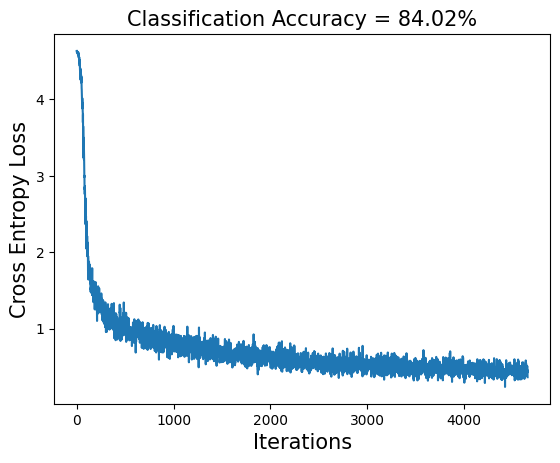

In [30]:
import numpy as np
fig, ax = plt.subplots(nrows = 1, ncols=1)
ax.plot(range(len(lossVals)),lossVals)
ax.set_xlabel('Iterations',fontsize = 15)
ax.set_ylabel('Cross Entropy Loss', fontsize = 15)
ax.set_title('Classification Accuracy = {:.2f}%'.format(accuracy),fontsize = 15)
path = 'dim_{}_accry_{:.2f}len_{}_hidden_{}'.format(dModel,accuracy, maxLen,hidden_size)
plt.savefig(path+'.pdf')

# SVM With LSTM 
### Instead of the 2 fully connected layers and 1 soft-max layer in the LSTM model above, we use multi-class SVM for classification below.

## 1) Declare LSTM model and load trained weights.

In [31]:
class w2nModelSVM(torch.nn.Module):
    def __init__(self,vocab_size, embedding_dim, hidden_size, nClasses):
        super(w2nModelSVM, self).__init__()
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.LSTM = nn.LSTM(input_size = embedding_dim, hidden_size = hidden_size,batch_first=True)

    def forward(self, x):
        x = self.word_embeddings(x)     # output dimensions is batch size = N x sequence length x feature size
        (x,_) = self.LSTM(x)        
        x = x[:, -1, :]                 # gives two dimensional output, not three dimensional output
        return x

modelSVM = w2nModelSVM(vocab_size = vocabSize, 
                 embedding_dim = dModel,
                 hidden_size=hidden_size, nClasses = numClasses
                )
modelSVM.word_embeddings.weight.data.copy_((model.word_embeddings.weight))
modelSVM.LSTM.load_state_dict(model.LSTM.state_dict())

AttributeError: 'trnsfrmrClassifier' object has no attribute 'LSTM'

## 2) Get LSTM Embeddings for Train and Test Dataset

In [14]:
numTrn = trainData.__len__()
trnEmbdngs = np.zeros((numTrn,hidden_size))
trnLbls  = []
modelSVM.eval()
for i, data in enumerate(trainLoader):
    inputs,labels_ = data
    outputs = modelSVM(inputs)
    trnEmbdngs[i*batchSize: (i+1)*batchSize,:] = outputs.detach().clone().numpy()
    trnLbls = trnLbls + [lblMap[x] for x in labels_]

numTst = testData.__len__()
tstEmbdngs = np.zeros((numTst,hidden_size))
tstLbls = [] 
for i, data in enumerate(testLoader):
    inputs,labels_ = data
    labels =  []
    outputs = modelSVM(inputs)
    tstEmbdngs = outputs.detach().clone().numpy()
    tstLbls = tstLbls + [lblMap[x] for x in labels_]

## 3) Accuracy using Linear SVM


In [ ]:
from sklearn import svm
clf = svm.SVC(decision_function_shape='ovo', kernel = 'linear')
clf.fit(trnEmbdngs, np.asarray(trnLbls))
TrnAccrcyLnr = clf.score(trnEmbdngs, np.asarray(trnLbls))
TstAccrcyLnr = clf.score(tstEmbdngs,np.asarray(tstLbls))
print(r'Train Accuracy of Linear SVM =', 100*TrnAccrcyLnr)
print(r'Test Accuracy of Linear SVM =', 100*TstAccrcyLnr)

## 4) Accuracy using RBF Kernel SVM

In [ ]:
clf = svm.SVC(decision_function_shape='ovo', kernel='rbf')
clf.fit(trnEmbdngs, trnLbls)
TrnAccrcyKrnl = clf.score(trnEmbdngs, trnLbls)
TstAccrcyKrnl = clf.score(tstEmbdngs,tstLbls)
print(r'Train Accuracy of Kernel SVM =', 100*TrnAccrcyKrnl)
print(r'Test Accuracy of Kernel SVM =', 100*TstAccrcyKrnl)